# Time Series and Forecasting Models: Facebook Prophet
## 1. Introduction
Prophet is an open source library published by Facebook in 2017 which is built upon scikit-learn time series modelling and automatically detects changes in trends by selecting changepoints from the data. It is an additive model where non-linear trends are fit with yearly, weekly, and daily seasonality, plus holiday effects, and includes automatic detection for all values.

## 2. Install/import libraries

In [1]:
!pip install fbprophet
!pip install yfinance
!pip install mplfinance

     |████████████████████████████████| 6.4 MB 31.7 MB/s 
     |████████████████████████████████| 63 kB 1.4 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.27.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
     |████████████████████████████████| 70 kB 5.3 MB/s 


In [2]:
import yfinance as yf

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.style as style
import matplotlib.patches as mpatches
from matplotlib.dates import date2num, DateFormatter, WeekdayLocator,\
    DayLocator, MONDAY
from mplfinance.original_flavor import candlestick_ohlc
import seaborn as sns

import datetime
from datetime import date, timedelta

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

%matplotlib inline

## 3. Import data

In [5]:
bn_stocks = yf.download("^NSEBANK HDFCBANK.NS KOTAKBANK.NS ICICIBANK.NS SBIN.NS YESBANK.NS", start=datetime.datetime(2010, 1, 1), 
                                     end=datetime.datetime(2022, 2, 15), group_by='tickers')
bn_stocks.head(10)

[*********************100%***********************]  6 of 6 completed


^NSEBANK               ... HDFCBANK.NS          
                   Open         High  ...   Adj Close    Volume
Date                                  ...                      
2010-01-04  9031.900391  9129.450195  ...  157.566528   3050490
2010-01-05  9191.250000  9214.000000  ...  157.705032   8386600
2010-01-06  9243.900391  9265.549805  ...  157.811264   6639840
2010-01-07  9240.250000  9261.849609  ...  158.222366   6123980
2010-01-08  9185.049805  9214.349609  ...  158.430176   7085900
2010-01-11  9209.150391  9248.000000  ...  157.792801  13766610
2010-01-12  9173.849609  9173.849609  ...  156.596527   4907050
2010-01-13  8912.599609  8937.849609  ...  156.051498  10346750
2010-01-14  8952.000000  9040.000000  ...  155.543442  10172640
2010-01-15  8961.650391  8982.549805  ...  156.499512  11581730

[10 rows x 36 columns]

In [6]:
bn =  bn_stocks['^NSEBANK']
                                     
bn.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-01-04,9031.900391,9129.450195,9031.900391,9112.349609,9112.349609,0.0
2010-01-05,9191.250000,9214.000000,9157.349609,9192.150391,9192.150391,0.0
2010-01-06,9243.900391,9265.549805,9183.650391,9223.000000,9223.000000,0.0
2010-01-07,9240.250000,9261.849609,9153.250000,9192.950195,9192.950195,0.0
2010-01-08,9185.049805,9214.349609,9141.450195,9160.700195,9160.700195,0.0


In [7]:
bn['Adj Close']

Date
2010-01-04     9112.349609
2010-01-05     9192.150391
2010-01-06     9223.000000
2010-01-07     9192.950195
2010-01-08     9160.700195
                  ...     
2022-02-08    38028.449219
2022-02-09    38610.250000
2022-02-10    39010.949219
2022-02-11    38517.250000
2022-02-14    36908.550781
Name: Adj Close, Length: 2991, dtype: float64

## 4. Format data for Prophet
The input to Prophet is always a dataframe with two columns: ds and y. The ds (datestamp) column should be of a format expected by Pandas, ideally YYYY-MM-DD for a date or YYYY-MM-DD HH:MM:SS for a timestamp. The y column must be numeric, and represents the measurement we wish to forecast.

In [15]:
# Create a dataframe that complies with Prophet requirements

prophet_bn_adj = bn[['Adj Close']].copy()

In [16]:
# Reset the index back so Dates are no longer indexed
prophet_bn_adj.reset_index(inplace=True)

# Rename the columns for use in FB prophet
prophet_bn_adj.rename(columns={'Date': 'ds', 'Adj Close': 'y'}, inplace=True)

prophet_bn_adj.head()

,ds,y
0,2010-01-04,9112.349609
1,2010-01-05,9192.150391
2,2010-01-06,9223.000000
3,2010-01-07,9192.950195
4,2010-01-08,9160.700195


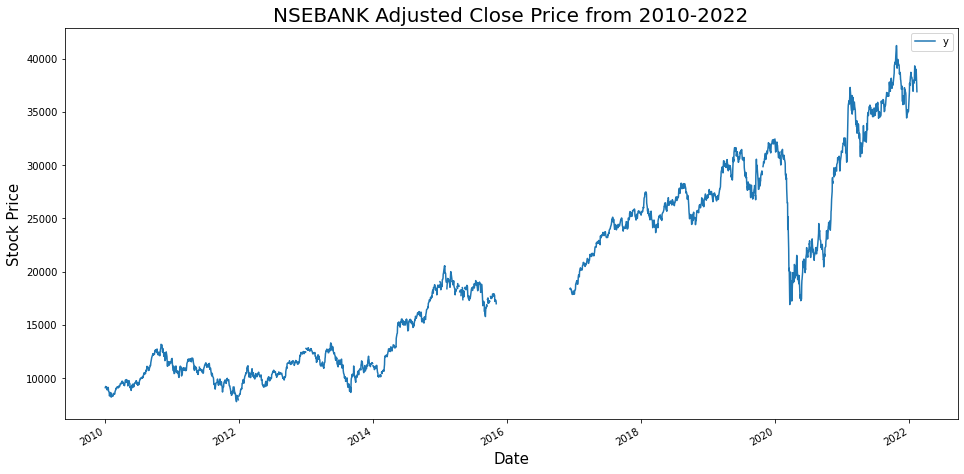

In [18]:
# Plot Adjusted Close price
pd.plotting.register_matplotlib_converters()
ax = prophet_bn_adj.set_index('ds').plot(figsize=(16,8))
ax.set_title('NSEBANK Adjusted Close Price from 2010-2022', color = 'black', fontsize = 20)
ax.set_ylabel('Stock Price', color = 'black', fontsize = 15)
ax.set_xlabel('Date', color = 'black', fontsize = 15)

plt.show()

## 5. Modelling
Prophet follows the sklearn model API. We create an instance of the Prophet class and then call its fit and predict methods.

### 5.1 Fit and train the model
Fit the model by instantiating a new Prophet object. Any settings to the forecasting procedure are passed into the constructor.

In [19]:
from fbprophet import Prophet
# Instantiate model and pass seasonality setting

m = Prophet(daily_seasonality = True)

Call the fit method and pass in the dataframe of dates and prices.

In [20]:
# fit the model

m.fit(prophet_bn_adj)

## 5.2 Create future dates to forecast
Predictions are then made on a dataframe with a column ds containing the dates for which a prediction is to be made. You can get a suitable dataframe that extends into the future a specified number of days using the helper method Prophet.make_future_dataframe.

In [21]:
# create a dataframe containing future dates to be forecast 
future = m.make_future_dataframe(periods=730, freq='D')     
future.tail()

,ds
3716,2024-02-10
3717,2024-02-11
3718,2024-02-12
3719,2024-02-13
3720,2024-02-14


## 5.3 Predictions
Forecasting future values in the dataframe containing dates for prediction.

In [22]:
# Pass the dataframe to the model with dates to predict future values
forecast = m.predict(future)

### Plot Actual vs Predicted prices

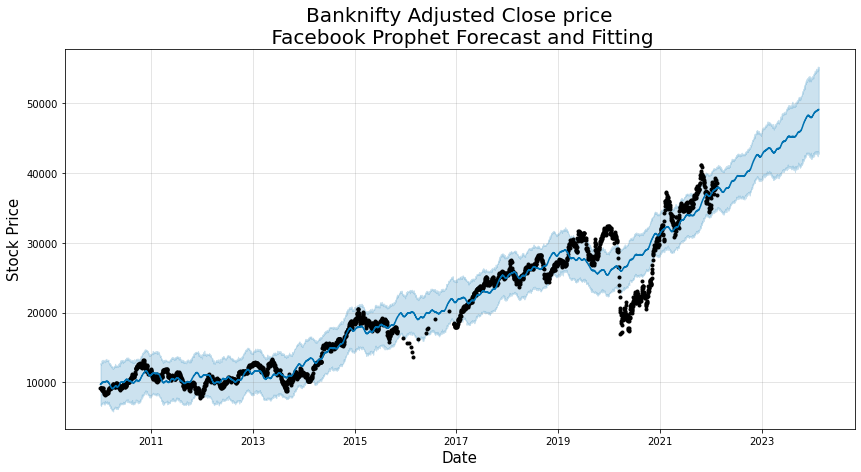

In [23]:
# Plot Forecast and Actual prices  
m.plot(forecast, uncertainty=True, figsize=(12,6))
plt.title('Banknifty Adjusted Close price\n Facebook Prophet Forecast and Fitting', color = 'black', fontsize = 20)
plt.xlabel("Date", color = 'black', fontsize = 15)
plt.ylabel("Stock Price", color = 'black', fontsize = 15)
plt.show()

In the above plot:

- Blue line = Forecasted values
- Black dots = Observed (actual) values
- Blue-shaded region = Confidence interval
### Trend Changepoints
Time series frequently have abrupt changes in their trajectories. By default, Prophet will automatically detect these changepoints and will allow the trend to adapt appropriately.

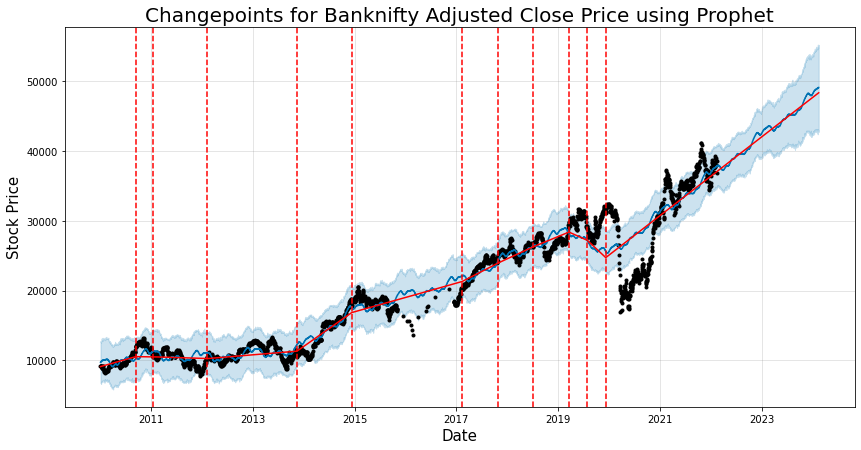

In [24]:
from fbprophet.plot import add_changepoints_to_plot

fig = m.plot(forecast, figsize=(12,6))
# the change points are added to our plot 
a = add_changepoints_to_plot(fig.gca(), m, forecast)
plt.title("Changepoints for Banknifty Adjusted Close Price using Prophet", color = 'black', fontsize = 20)
plt.xlabel("Date", color = 'black', fontsize = 15)
plt.ylabel("Stock Price", color = 'black', fontsize = 15)
plt.show()

By default, Prophet adds 25 changepoints into the initial 80% of the data set. Taking a look at the possible changepoints (dotted red lines) in the above chart, we can see they fit quite well with some of the highs and lows.

### Plot magnitudes of changepoints
Prophet will also let us take a look at the magnitudes of these possible changepoints.

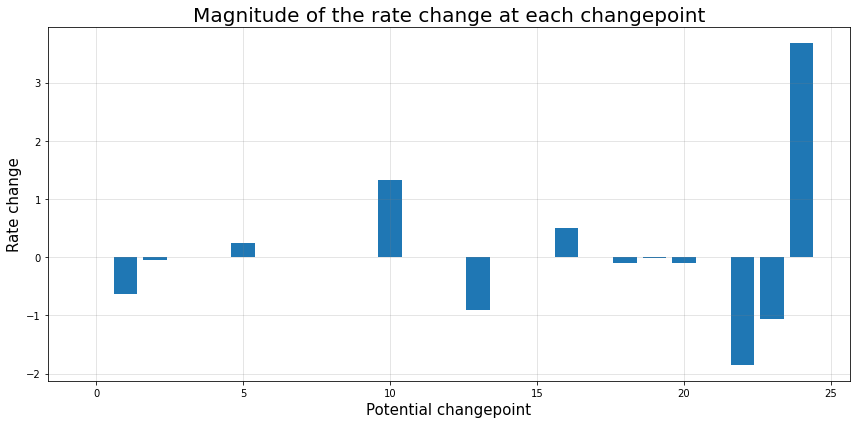

In [25]:
deltas = m.params['delta'].mean(0) 
fig = plt.figure(facecolor='w', figsize=(12,6))
ax = fig.add_subplot(111)
ax.bar(range(len(deltas)), deltas)
ax.grid(True, which='major', c='gray', ls='-', lw=1, alpha=0.2)
plt.title('Magnitude of the rate change at each changepoint', color = 'black', fontsize = 20)
ax.set_ylabel('Rate change', color = 'black', fontsize = 15)
ax.set_xlabel('Potential changepoint', color = 'black', fontsize = 15)
fig.tight_layout()

We can see that the red dotted lines in the plot of changepoints correspond with plot above of the magnitude of the rate change at each changepoint. Even though we have a lot of places where the rate can possibly change, because of the sparse prior, most of these changepoints go unused.

### Extract changepoints
If we want to use something like this in a model, we need a way of extracting changepoint data.

In [26]:
# View changepoints

m.changepoints

86     2010-05-12
173    2010-09-13
259    2011-01-14
345    2011-05-23
432    2011-09-27
518    2012-02-08
605    2012-06-18
691    2012-10-23
777    2013-03-01
864    2013-07-09
950    2013-11-14
1036   2014-03-24
1123   2014-07-31
1209   2014-12-12
1295   2015-05-05
1382   2015-09-09
1468   2017-02-08
1554   2017-06-15
1641   2017-10-24
1727   2018-02-27
1814   2018-07-04
1900   2018-11-12
1986   2019-03-19
2073   2019-07-29
2159   2019-12-09
Name: ds, dtype: datetime64[ns]

### Plot components of the forecasts

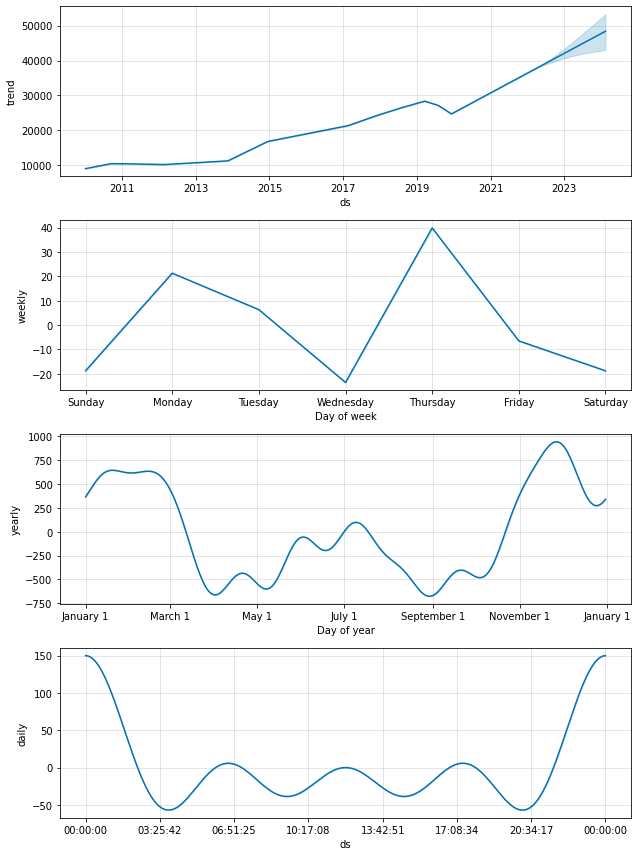

In [27]:
# Plot the trend, weekly, yearly and daily components

m.plot_components(forecast)
plt.show()

Our data has some seasonal information present. Based on the estimated trends, we can see from the yearly subplot that, usually, the stock price is highest in mid-August and, according to the weekly subplot, mostly on Fridays. Inevitably, the daily subplot shows that the stock price fluctuates throughout the day.

Finally, the trend subplot shows an upward trend including an increase in the stock price between mid 2020 and beginning of 2022). The dataset only contained data up to the end of 2019 so this prediction does not reflect any impact of Covid-19.